In [1]:
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import numpy as np
import datetime
import time

import random

import math
import pandas as pd

In [2]:
import os
print(os.getcwd())

C:\Users\surya


In [3]:
os.chdir(r'F:/Portfolio/UFL/')

In [4]:
data_path = r"data/M/O/"
filename = 'MO1'

In [5]:
with open(data_path+filename) as file:
    sizes = np.fromstring(file.readline(), dtype=int, sep=" ")
    m, n = sizes[0], sizes[1] # m = no. of customers; n = no. of facilites
    print(m, n)
    capacity = np.empty(n)
    opening_cost = np.empty(n)
    demand = np.empty(m)
    serving_cost = np.empty([m, n])
    for i in range(n):
        section_1_line = np.fromstring(file.readline(), dtype=float, sep=" ")
        capacity[i], opening_cost[i] = section_1_line[0], section_1_line[1]
    for i in range(m):
        demand[i] = np.fromstring(file.readline(), dtype=float, sep=" ")
        serving_cost[i, :] = np.fromstring(file.readline(), dtype=float, sep=" ")

100 100


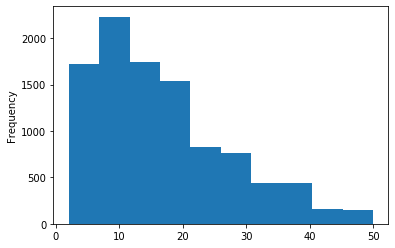

In [6]:
dff = pd.Series(serving_cost.flatten())
dff.plot.hist()

In [7]:
n_client = len(demand)
n_facility = len(opening_cost)
print(n_client, "Demand Locations or Clients")

print(n_facility, "Facilities")

100 Demand Locations or Clients
100 Facilities


In [8]:
opening_cost

array([200.55  , 212.658 ,  95.921 , 117.834 , 171.031 , 256.357 ,
       218.632 , 171.061 , 180.971 , 168.295 , 159.696 , 196.258 ,
       157.606 , 162.212 , 102.261 , 109.421 , 124.012 , 168.598 ,
       105.592 , 168.381 , 131.903 , 190.719 , 116.779 ,  50.    ,
        94.175 , 110.655 , 211.602 , 143.065 , 163.495 , 136.551 ,
        73.6585, 214.622 , 223.719 ,  99.4707, 203.919 , 207.559 ,
        80.861 , 251.72  , 150.969 , 250.894 , 243.853 , 131.426 ,
       241.631 , 149.976 ,  65.3497, 166.159 ,  69.8907, 225.944 ,
       133.146 ,  90.6736, 140.899 , 178.587 , 300.    , 117.857 ,
       182.391 , 137.279 , 159.54  , 129.923 ,  71.5244, 119.644 ,
       133.431 , 230.612 , 133.794 , 190.345 , 158.711 , 152.179 ,
       179.039 , 143.685 , 203.228 , 163.309 , 156.848 , 227.786 ,
       166.931 , 151.377 , 284.253 , 119.007 , 152.611 , 174.067 ,
       197.942 , 154.078 , 238.836 , 214.227 , 269.128 , 104.872 ,
        61.2307, 149.104 , 154.132 , 152.156 , 173.297 , 123.2

In [9]:
df = pd.DataFrame(serving_cost).head(10)
df = df.rename_axis("Facilities", axis="columns")
df = df.rename_axis("Clients", axis="rows")

In [10]:
df.head(5)

Facilities,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Clients,,,,,,,,,,,,,,,,,,,,,
0,2.37627,5.31695,5.57118,5.83591,9.15027,5.82114,5.77960,5.67768,4.49169,6.72159,...,6.46666,2.17409,3.42665,4.39220,7.97902,5.49366,5.04129,8.15626,3.59279,4.40500
1,9.45280,3.21590,7.81713,6.76244,8.37225,4.75309,4.95507,5.71846,4.03081,8.64646,...,6.50485,4.65022,7.14090,4.46423,4.46473,5.88768,7.99023,6.40044,3.12517,7.52048
2,17.18240,5.51389,15.24870,10.05870,5.66571,11.18050,4.92069,19.05850,12.24140,4.41981,...,18.32730,13.46990,4.83425,9.93675,6.29434,10.62850,19.63810,8.94523,19.53320,7.04157
3,8.27847,7.92073,8.12976,7.45249,7.86574,4.25142,3.49568,7.83872,3.50782,9.26896,...,6.16701,8.55182,2.00478,7.41689,4.18369,9.23453,8.91085,2.15172,3.20007,8.19683
4,3.99216,5.89499,9.66227,6.38394,6.88412,6.33420,8.17981,2.32795,7.02377,7.42180,...,7.02252,7.86589,4.46928,2.65191,6.82275,2.42109,4.28059,6.75315,2.41353,9.38202


In [11]:
model = gp.Model('UFL disaggregated')

# Variables
# 2d indices
# x[i,j] = Fraction of client i demand served by facility j

x = model.addVars(n_client, n_facility, obj=serving_cost, vtype=GRB.CONTINUOUS, name='x')
y = model.addVars(n_facility, obj=opening_cost, vtype=GRB.BINARY, name='y')

#model.addConstrs((x.sum(m, '*') == demand[i] for m in range(n_client)), name='assignment_cons') #tupledict.sum()
#model.addConstrs((x[i,j] <= demand[i]*y[j] for i in range(n_client) for j in range(n_facility)), name='disagg_cons')
model.addConstrs((x.sum(m, '*') == 1 for m in range(n_client)), name='assignment_cons') #tupledict.sum()
model.addConstrs((x[i,j] <= y[j] for i in range(n_client) for j in range(n_facility)), name='disagg_cons')

model.ModelSense = GRB.MINIMIZE
#model.setObjective(x.prod() + gp.quicksum(y), GRB.MINIMIZE)
model.write('ufl_1v1.lp')
model.optimize()

Using license file C:\Users\surya\gurobi.lic
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (win64)
Optimize a model with 10100 rows, 10100 columns and 30000 nonzeros
Model fingerprint: 0x9d3b7902
Variable types: 10000 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 12077.048790
Presolve time: 0.03s
Presolved: 10100 rows, 10100 columns, 30000 nonzeros
Variable types: 10000 continuous, 100 integer (100 binary)

Root relaxation: objective 1.267061e+03, 4575 iterations, 0.14 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1267.06052    0   18 12077.0488 1267.06052  89.5%     -    0s
H    0     0                    2648.6145546 1267.06052 

In [177]:
serving_cost[0]
opening_cost
x_ans = [x[i].getAttr('x') for i in x] 
x_ans = np.array(x_ans)
x_ans = x_ans.reshape(200,200)
y_ans = [y[i].getAttr('x') for i in y] 
lp_fcost = y_ans * opening_cost
lp_scost = x_ans * serving_cost

In [12]:
model.printAttr('x')


    Variable            x 
-------------------------
     x[0,98]            1 
     x[1,98]            1 
     x[2,84]            1 
     x[3,98]            1 
     x[4,98]            1 
     x[5,98]            1 
     x[6,84]            1 
     x[7,58]            1 
     x[8,58]            1 
     x[9,98]            1 
    x[10,23]            1 
    x[11,84]            1 
    x[12,44]            1 
    x[13,44]            1 
    x[14,23]            1 
    x[15,23]            1 
    x[16,98]            1 
    x[17,84]            1 
    x[18,84]            1 
    x[19,23]            1 
    x[20,23]            1 
    x[21,23]            1 
    x[22,98]            1 
    x[23,98]            1 
    x[24,44]            1 
    x[25,84]            1 
    x[26,44]            1 
    x[27,44]            1 
    x[28,84]            1 
    x[29,23]            1 
    x[30,44]            1 
    x[31,98]            1 
    x[32,98]            1 
    x[33,58]            1 
    x[34,58]            1 
 

In [13]:
model = gp.Model('UFL agg')

# Variables
# 2d indices
# x[i,j] = Fraction of client i demand served by facility j

x = model.addVars(n_client, n_facility, obj=serving_cost, vtype=GRB.CONTINUOUS, name='x')
y = model.addVars(n_facility, obj=opening_cost, vtype=GRB.BINARY, name='y')

#model.addConstrs((x.sum(m, '*') == demand[i] for m in range(n_client)), name='assignment_cons') #tupledict.sum()
#model.addConstrs((x[i,j] <= demand[i]*y[j] for i in range(n_client) for j in range(n_facility)), name='disagg_cons')

# one customer can be mapped exactly by 1 facility
model.addConstrs((x.sum(m, '*') == 1 for m in range(n_client)), name='assignment_cons') #tupledict.sum()
# One location can take a max of n_client customers
model.addConstrs((x.sum('*', j) <= n_client*y[j] for j in range(n_facility)), name='Agg_cons')

model.ModelSense = GRB.MINIMIZE
#model.setObjective(x.prod() + gp.quicksum(y), GRB.MINIMIZE)
model.write('ufl_1v1.lp')
model.optimize()

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (win64)
Optimize a model with 200 rows, 10100 columns and 20100 nonzeros
Model fingerprint: 0x3e94ebde
Variable types: 10000 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [2e+00, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 12077.048790
Presolve time: 0.01s
Presolved: 200 rows, 10100 columns, 20100 nonzeros
Variable types: 10000 continuous, 100 integer (100 binary)

Root relaxation: objective 7.052319e+02, 289 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  705.23187    0   52 12077.0488  705.23187  94.2%     -    0s
H    0     0                    7327.4216000  705.23187  90.4%     -    0s
H    0     0                    5507.8927400  705.23187  87.2%     -    0s
H  

# Interpretation:
1. In the aggregated case, root relaxation took longer
2. In the disaggregated case, root relaxation is faster
(Reasons are obvious)
3. However, the solver solved the aggregated case IP faster. (Ofcourse, it will as long as the size is handle-able)

In [77]:
%%cython
import gurobipy as gp
def dm():
    cpdef long long sus = 0
    cpdef long long i
    cpdef long long x = int(1e4)
    m1 = gp.Model('try')
    m1.addVar()
    for i in range(1, x):
        sus = sus + i
        m1.addVar()
    print(sus)
    m1.update()
    print(len(m1.getVars()))

In [235]:
@njit
def sm():
    sus = 0
    x = int(1e100)
    for i in range(1, x):
        sus = sus + i
    print(sus)

In [69]:
from distutils.core import setup
from Cython.Build import cythonize

In [30]:
m1.getVars()

[]

In [ ]:
sm()

In [70]:
%load_ext Cython


    Variable            x 
-------------------------
     x[0,58]            1 
     x[0,98]            1 
     x[1,84]            1 
     x[1,98]            1 
     x[2,84]            2 
     x[3,18]            1 
     x[3,98]            1 
     x[4,84]            1 
     x[4,98]            1 
     x[5,98]            2 
     x[6,84]            2 
     x[7,58]            2 
     x[8,18]            2 
     x[9,23]            1 
     x[9,98]            1 
    x[10,18]            2 
    x[11,18]            2 
    x[12,44]            2 
    x[13,44]            2 
    x[14,23]            2 
    x[15,23]            2 
    x[16,18]            1 
    x[16,98]            1 
    x[17,84]            1 
    x[17,89]            1 
    x[18,18]            1 
    x[18,89]            1 
    x[19,23]            1 
    x[19,58]            1 
    x[20,89]            2 
    x[21,23]            2 
    x[22,89]            1 
    x[22,98]            1 
    x[23,98]            2 
    x[24,89]            2 
 

In [15]:
model.computeIIS()
model.write('infeas.ilp')

IIS runtime: 0.00 seconds


GurobiError: Cannot compute IIS on a feasible model

In [11]:
x_old = [x[i,j].getAttr('x') for i in range(n_client) for j in range(n_facility)]

AttributeError: Unable to retrieve attribute 'x'

In [12]:
x_old

NameError: name 'x_old' is not defined

In [25]:
x_lp = [x[i,j].getAttr('x') for i in range(n_client) for j in range(n_facility)]

In [38]:
[x==y for x,y in zip(x_old, x_lp)]

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,


In [34]:
182919 - 10*5000

132919

In [33]:
sum([y[i].getAttr('x') for i in range(n_facility)])

10.0

In [41]:
np.all([x== int(x) for x in x_lp])

True